# Subtracting a noise line from strain data

This tutorial explains how to use data from an auxiliary channel to measure the amplitude of a line in LIGO data. We can then use the relationship between the strain data and this auxiliary channel to subtract the line from the strain data. 

Code similar to that introduced in this tutorial is used to subtract lines from LIGO data before further analysis. In practice, additional concerns should be taken into account, such as the variability of the transfer function between the auxiliary channel and the strain data. You can find more details about how lines were subtracted from LIGO data in O3 in the following publication: 

* [O3 Technical note on line subtraction](https://dcc.ligo.org/LIGO-T2100058/public)

## Get data

In this case, we will subtract a line that LIGO scientists added to the data to calibrate the data. The source of this line is a photon calibrator (PCal) that is using a laser to move the mirrors in a predictable way. Let's first download strain data and photon calibrator data. 

In [1]:
from gwpy.timeseries import TimeSeries

gps = 1264316116 #time of GW200129_065458
gps_exact = 1264316116.4

data_window = 1024
data_start = gps - data_window
data_end = gps + data_window



In [2]:
strain_data = TimeSeries.fetch('H1:DCS-CALIB_STRAIN_C01_AR', 
                        start=data_start, end=data_end, host='losc-nds.ligo.org').resample(4096)

In [3]:
aux_data = TimeSeries.fetch('H1:CAL-PCALY_RX_PD_OUT_DQ', 
                        start=data_start, end=data_end, host='losc-nds.ligo.org').resample(4096)

## Visualize data

Let's now take a quick look at the data we downloaded. First, we can calculate the amplitude spectral density of the two data streams and plot the result. 

When we zoom into frequencies near 17 Hz, we notice that both channels have a peak in the noise near 17.1 Hz. This is the calibration line we will focus on. 

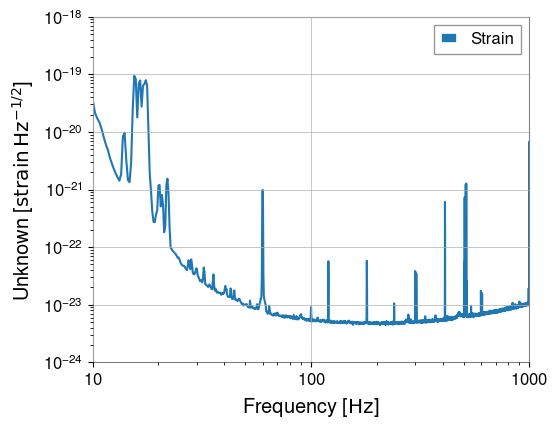

In [4]:
plot = strain_data.asd(4,2).plot(label='Strain')
ax = plot.gca()
ax.set_xlim(10, 1000)
ax.set_ylim(1e-24, 1e-18)
ax.legend(loc='upper right')
plot.show()

In [5]:
aux_asd = aux_data.asd()
strain_asd = strain_data.asd()

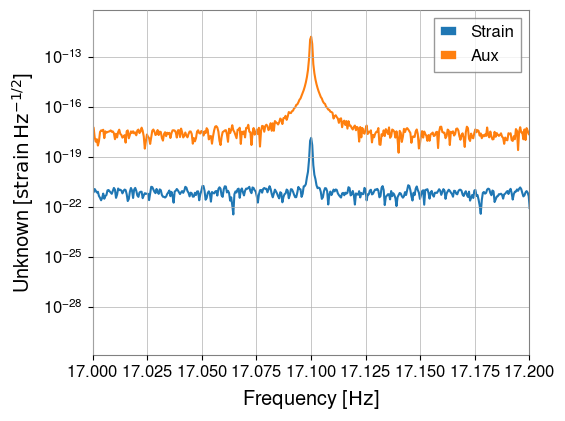

In [6]:
plot = strain_asd.plot(label='Strain')
ax = plot.gca()
ax.plot(aux_asd, label='Aux')
ax.set_xlim(17.0, 17.2)
ax.set_xscale('linear')
ax.legend(loc='upper right')
plot.show()

## Demodulate the data

Next, we will use a technique known as *demodulation* to measure the amplitude of the line with respect to time in both the PCal channel and the strain channel. This will make it easier to work with the data later. More details on (de)modulation can be found in the following article:

* [Modulation](https://en.wikipedia.org/wiki/Modulation)

Before we work with this data, we are going to preform a few filtering steps:

1. We first want to apply notch filters at 15.6 Hz, 16.4 Hz, and 17.6 Hz. These frequencies correspond to other calibration lines near the specific line we are subtracting. We will apply a notch filter at each frequency to reduce the chance that these nearby lines bias our result. 
2. We then bandpass the data between 17.075 and 17.125 Hz. This small frequency range around our frequency of interest (17.1 Hz) will ensure that our data contains only the line we are trying to subtract.

In [7]:
import numpy as np

pcal_freq = 17.1 # Hz
exp_array = np.exp(-1j*aux_data.times.value*2*np.pi*pcal_freq)
exp_ts = TimeSeries(exp_array, times = aux_data.times.value)#.astype(np.float64)

In [8]:
demod_aux = exp_ts.copy() * aux_data.copy().bandpass(17.075, 17.125).notch(15.6).notch(16.4).notch(17.6)
demod_strain = exp_ts.copy() * strain_data.copy().bandpass(17.075, 17.125).notch(15.6).notch(16.4).notch(17.6)

In [9]:
lp = 1./10.

strain_crop = aux_data.copy().crop(demod_strain.epoch.value+60*10, 
                                  demod_strain.epoch.value+60*20)
aux_crop = aux_data.copy().crop(demod_aux.epoch.value+60*10, 
                                  demod_aux.epoch.value+60*20)

# strain data
demod_strain_amp = np.abs(demod_strain.lowpass(lp).crop(demod_strain.epoch.value+60*10, 
                                  demod_strain.epoch.value+60*20))

demod_strain_phase = np.angle(demod_strain.lowpass(lp).crop(demod_strain.epoch.value+60*10, 
                                  demod_strain.epoch.value+60*20))

strain_amp = np.mean(demod_strain_amp.value)
strain_phase = np.mean(demod_strain_phase.value)

# aux data
demod_aux_amp = np.abs(demod_aux.lowpass(lp).crop(demod_aux.epoch.value+60*10, 
                                  demod_aux.epoch.value+60*20))

demod_aux_phase = np.angle(demod_aux.lowpass(lp).crop(demod_aux.epoch.value+60*10, 
                                  demod_aux.epoch.value+60*20))

aux_amp = np.mean(demod_aux_amp.value)
aux_phase = np.mean(demod_aux_phase.value)

Now that we have demodulated our signal, let's plot the amplitude with respect to time!

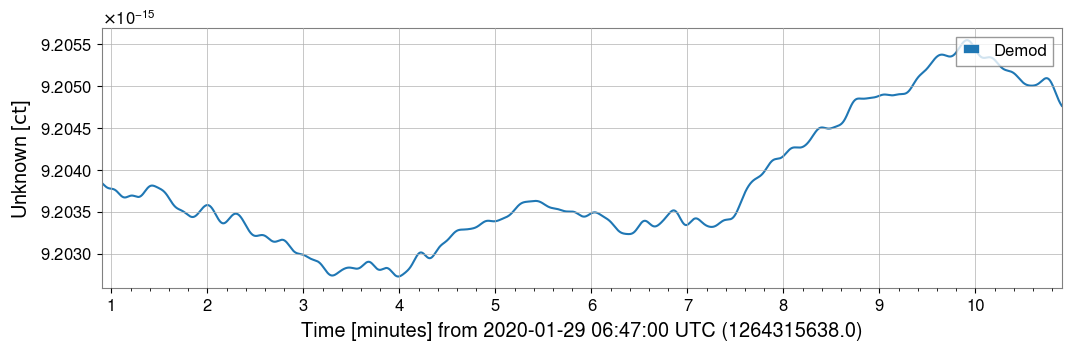

In [10]:
plot = demod_aux_amp.plot(label='Demod')
ax = plot.gca()
ax.legend(loc='upper right')
plot.show()

We can see that the amplitude is slowly varying! However, the variation is relatively small. Hence it is likely ok to take the mean amplitude and use that for the entire time period we are considering. We can multiply the PCal channel by the relative amplitude between the strain channel and the PCal channel to account for the amplitude difference between the two channels. 

We then can replot the spectra of each channel. We now see that the two channels line up very well!

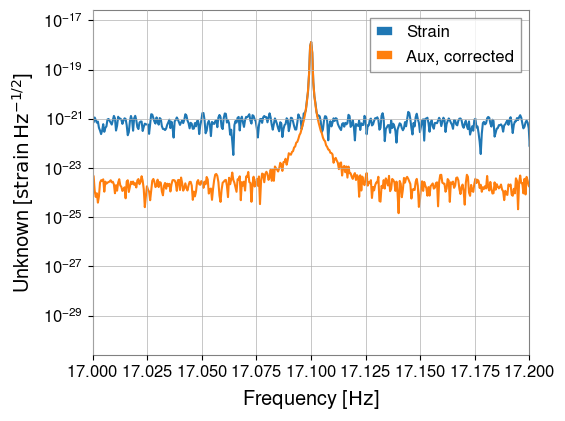

In [11]:
plot = strain_asd.plot(label='Strain')
ax = plot.gca()
ax.plot(aux_asd*abs(strain_amp/aux_amp), label='Aux, corrected')
ax.set_xlim(17.0, 17.2)
ax.set_xscale('linear')
ax.legend(loc='upper right')
plot.show()

## Subtract line from the data

In order to subtract this line, we will consider the amplitude and phase from our demodulation process to recreate how the signal appears in the strain. Then, we can compare the data once more before subtracting our line model from the strain channel.  

In [12]:
aux_sub_array = (aux_data.fft()*abs(strain_amp/aux_amp) *
                np.exp(1j*(strain_phase-aux_phase))).ifft().value
aux_sub = TimeSeries(np.real(aux_sub_array), times = aux_data.times.value)

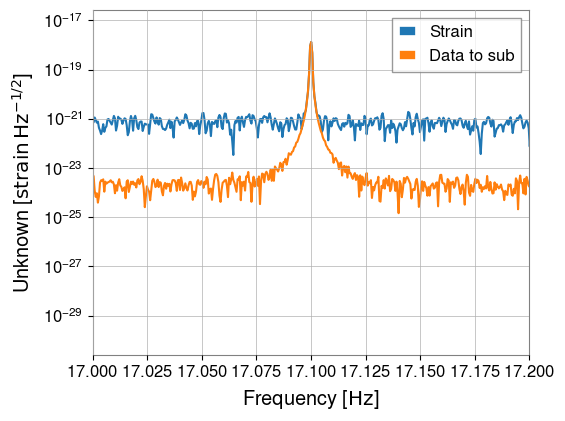

In [13]:
plot = strain_data.asd(aux_sub.duration.value).plot(label='Strain')
ax = plot.gca()
ax.plot(aux_sub.asd(), label='Data to sub')
ax.set_xlim(17.0, 17.2)
ax.set_xscale('linear')
ax.legend(loc='upper right')
plot.show()

In [14]:
bp_sub = aux_sub.copy().bandpass(17.075, 17.125)
bp_strain = strain_data.copy().bandpass(17.075, 17.125)

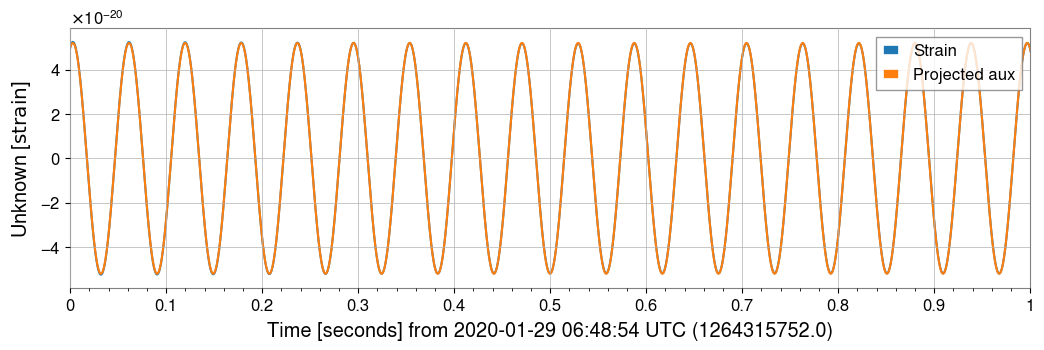

In [15]:
plot = bp_strain.plot(label='Strain')
ax = plot.gca()
ax.plot(bp_sub, label='Projected aux')
ax.set_xlim(bp_sub.epoch.value+60*11, bp_sub.epoch.value+60*11+1)
ax.legend(loc='upper right')
plot.show()

Things look good! Let's proceed with the subtraction. 

In [16]:
data_sub = TimeSeries(strain_data.value - aux_sub.value, times=strain_data.times.value)

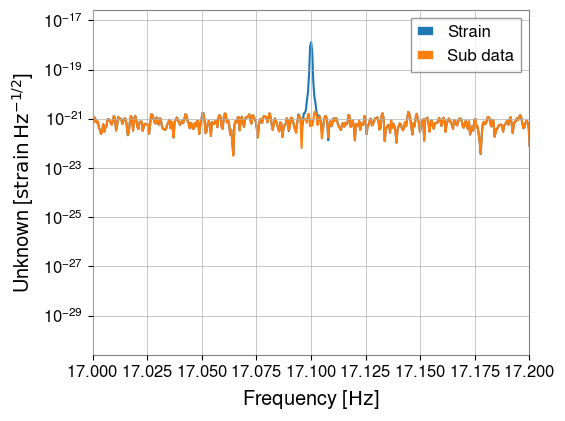

In [17]:
plot = strain_data.asd(data_sub.duration.value).plot(label='Strain')
ax = plot.gca()
ax.plot(data_sub.asd(), label='Sub data')
#ax.plot(aux_sub.asd(), label='Data to sub')
ax.set_xlim(17.0, 17.2)
ax.set_xscale('linear')
ax.legend(loc='upper right')
plot.show()

Comparing the data before and after subtraction we find that the line is no longer visible in the data!